# This is a tool for looking at HDX/MS data, LacI structure, and mutational phenotypes for particular LacI peptides in one or more functional states.

![LacI peptides and structure.](lacI_diagram_table.png)

### First choose the state(s).

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pytraj as pt
import nglview as nv
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import seaborn as sns
import ipywidgets as widgets
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter


print('Choose from the following functional states: ')
CBwidget_IPTG = widgets.Checkbox(description = 'IPTG, an inducer molecule', value=True, disabled=False)
CBwidget_ONPF = widgets.Checkbox(description = 'ONPF, an anti-inducer molecule', value=True, disabled=False)
CBwidget_APO = widgets.Checkbox(description = 'APO protein', value=False, disabled=False)
CBwidget_DNA = widgets.Checkbox(description = 'operator DNA', value=True, disabled=False)
CBwidget_TMG = widgets.Checkbox(description = 'TMG, an inducer molecule', value=False, disabled=False)
CBwidget_ONPFDNA = widgets.Checkbox(description = 'ONPF and operator DNA', value=False, disabled=False)

display(CBwidget_IPTG, CBwidget_ONPF, CBwidget_APO, CBwidget_DNA, CBwidget_TMG, CBwidget_ONPFDNA)

Choose from the following functional states: 


Checkbox(value=True, description='IPTG, an inducer molecule')

Checkbox(value=True, description='ONPF, an anti-inducer molecule')

Checkbox(value=False, description='APO protein')

Checkbox(value=True, description='operator DNA')

Checkbox(value=False, description='TMG, an inducer molecule')

Checkbox(value=False, description='ONPF and operator DNA')

In [28]:
states_list = []

if CBwidget_IPTG.value == True:
    states_list.append('IPTG')
if CBwidget_ONPF.value == True:
    states_list.append('ONPF')
if CBwidget_APO.value == True:
    states_list.append('APO')
if CBwidget_DNA.value == True:
    states_list.append('DNA')
if CBwidget_TMG.value == True:
    states_list.append('TMG')
if CBwidget_ONPFDNA.value == True:
    states_list.append('ONPFDNA')

print('Chosen states:'); print(*states_list)

res_peptides_file = pd.ExcelFile('peptide_list.xlsx')

states_dict = {}
peptide_states_list = ['peptide']
for state in states_list:
    states_dict[state] = pd.read_excel(res_peptides_file)
    peptide_states_list.append(state)
        
single_state_dict = states_dict.get(states_list[0])
all_peptides = single_state_dict[['peptide']].values.tolist()
all_peptides_2 = []
first_res = single_state_dict[['first_res']].values.tolist()
index = 0

while index < len(all_peptides):
    current_first_res = str(int(first_res[index][0]))
    all_peptides_2.append(current_first_res + ' - ' + all_peptides[index][0])
    index = index + 1

Chosen states:
IPTG DNA ONPFDNA


### Compile exchange information for each peptide for chosen states.

In [29]:
############

def getIndexes(dfObj, value):
    listOfPos = []
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    return listOfPos

############

# create dictionary keys from peptides
# in subsequent code: add state and each TP avg exchange measurements as values for peptide keys
peptide_exchange_dict = {}
for peptide in all_peptides:
    peptide_exchange_dict[peptide[0]] = []

for state in states_dict:
    i = 0 # peptide counter
    for peptide in states_dict[state]['peptide']:
        peptide_first_res = states_dict[state]['first_res'][i]
        peptide_last_res = states_dict[state]['last_res'][i]

        peptide_file = pd.ExcelFile('~/Dropbox/Research/Data/HDX/20200816/20200819_fitting/' + str(peptide_first_res)
                                    + '_' + str(peptide_last_res) + '_' + peptide + '_fitting.xlsx')
        raw_df = pd.read_excel(peptide_file, 'Peptide SD', nrows = 15)
        
        column_vals = []
        listOfPositions = getIndexes(raw_df, state)
        for j in range(len(listOfPositions)):
            temp_string = (listOfPositions[j][1])
            position = int(temp_string[-2:])
            column_vals.append(position) # columns in spreadsheet corresponding to data label

        peptide_exchange = {}
        for element in column_vals:
            if state.lower() == (raw_df.iloc[2][element]).lower():
                peptide_exchange[state] = list(raw_df.iloc[4:13,element+2])
        
        peptide_exchange_dict[peptide].append(peptide_exchange)
        
        i = i + 1

### Plot H/D exchange functions as uptake plots for each peptide for each state.

In [30]:
# fitting

def exchange_fit(x, a, b, c, d, e, f, g):
    max_protons = a + b + c + g - 2 - num_prolines
    d > e
    e > f
    d > f
    return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g

def exchange_fit_low(x, b, c, e, f, g):
    max_protons = b + c + g - 2 - num_prolines
    e > f
    return max_protons - b * np.exp(-e * x) - c * np.exp(-f * x) - g

timepoints = [0, 30, 45, 60, 300, 1500, 3600, 7200, 14400]
trialT = np.logspace(1.5, 4.5, 10000)


# create dictionary keys from peptides
# in subsequent code: add state and FITS (long vectors) as values for peptide keys (peptide_fit_dict)
# add state and popt curvefit PARAMS for peptide keys (peptide_params_dict)

peptide_fit_dict = {}
peptide_params_dict = {}
for peptide in all_peptides:
    peptide_fit_dict[peptide[0]] = []
    peptide_params_dict[peptide[0]] = []

for peptide in peptide_exchange_dict:

    num_prolines = peptide[2:].count('P')
    max_protons = len(peptide) - 2 - num_prolines
    
    for element in peptide_exchange_dict.get(peptide): # element is state
        [exchange_list] = element.values() # these are the avg tp measurements for the state
        
        for state in element.keys():

            # create sub-dictionaries that links state (key) to fits or params (values),
            # then add sub-dicts as values to peptide_fit_dict or peptide_params_dict
            
            sub_fit_dict = {}
            sub_params_dict = {}
            
            p1_index = 0
            peptide1_tps = []
            peptide1_ex = []
            for tp in exchange_list:
                if not math.isnan(float(tp)):
                    peptide1_tps.append(timepoints[p1_index])
                    peptide1_ex.append(float(tp))
                p1_index = p1_index + 1

            if peptide1_ex[-1] > .5:

                popt, pcov = curve_fit(f = exchange_fit, xdata = peptide1_tps, ydata = peptide1_ex,
                                       bounds = (0, [max_protons, max_protons, max_protons, 1, .1, .01, max_protons]),
                                       maxfev = 100000)
                exchange_peptide1 = exchange_fit(trialT, *popt)
                perr = np.sqrt(np.diag(pcov))

            else:

                popt, pcov = curve_fit(f = exchange_fit_low, xdata = peptide1_tps, ydata = peptide1_ex,
                                       bounds = (0, [max_protons, max_protons, .1, .01, max_protons]),
                                       maxfev = 100000)
                exchange_peptide1 = exchange_fit_low(trialT, *popt)
                perr = np.sqrt(np.diag(pcov))

            sub_fit_dict[state] = exchange_peptide1
            sub_params_dict[state] = popt
            peptide_fit_dict[peptide].append(sub_fit_dict)
            peptide_params_dict[peptide].append(sub_params_dict)

### Perform k-means clustering on medium-exchanging protons for selected states.

IPTG
DNA
ONPFDNA


(1e-05, 10)

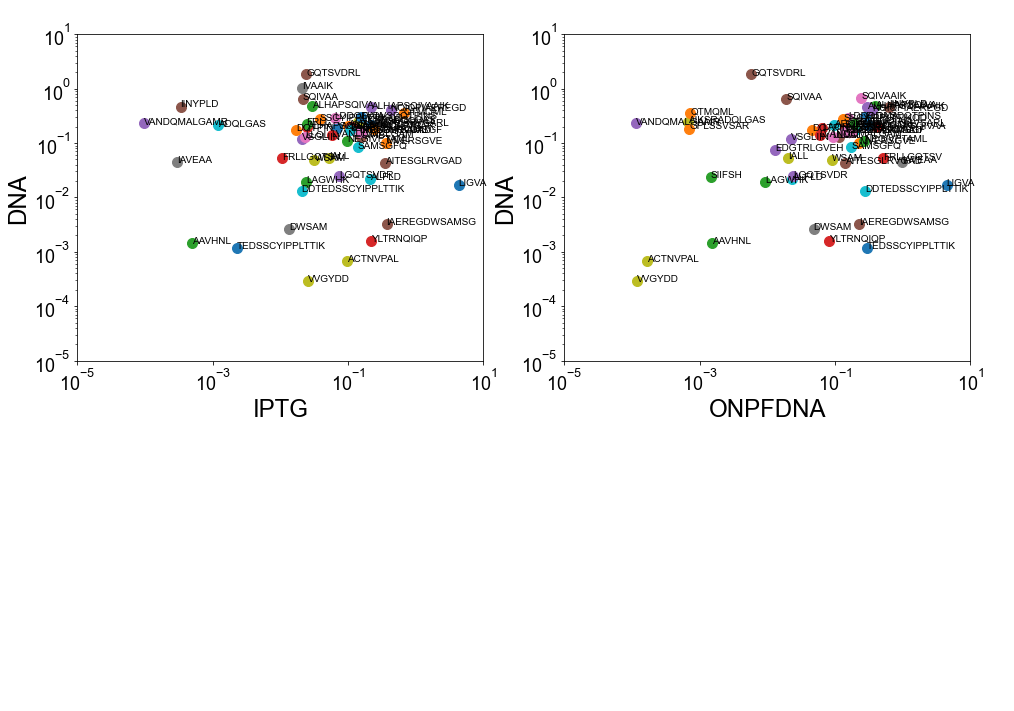

In [88]:
            
# for key in peptide_params_dict.keys():
#     print(key)
#     print(len(peptide_params_dict.get(key)))
#     print(peptide_params_dict.get(key)[0])
#     print(peptide_params_dict.get(key)[1])
#     print(peptide_params_dict.get(key)[2])
#     for x in peptide_params_dict.get(key)[2].values():
#         for y in x:
#             print(y)

compare_med_dict = {}
for [peptide] in all_peptides:
    compare_med_dict[peptide] = []
    
compare_med_dict_ = {}
for [peptide] in all_peptides:
    compare_med_dict_[peptide] = []

state1 = str(peptide_params_dict.get(peptide)[0].keys())
state1 = state1[12:-3]
print(state1)

state2 = str(peptide_params_dict.get(peptide)[1].keys())
state2 = state2[12:-3]
print(state2)

state3 = str(peptide_params_dict.get(peptide)[2].keys())
state3 = state3[12:-3]
print(state3)

#     return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g
#     return max_protons - b * np.exp(-e * x) - c * np.exp(-f * x) - g

for peptide in peptide_params_dict.keys():
    state1_params = []
    for x in peptide_params_dict.get(peptide)[0].values(): 
        for y in x:
            state1_params.append(y)
    if len(state1_params) > 5:
        state1_med = (state1_params[1]*state1_params[4]) + (state1_params[2]*state1_params[5])
    else:
        state1_med = (state1_params[0]*state1_params[3]) + (state1_params[1]*state1_params[4])
    
    state2_params = []
    for x in peptide_params_dict.get(peptide)[1].values(): 
        for y in x:
            state2_params.append(y)
    if len(state2_params) > 5:
        state2_med = (state2_params[1]*state2_params[4]) + (state2_params[2]*state2_params[5])
    else:
        state2_med = (state2_params[0]*state2_params[3]) + (state2_params[1]*state2_params[4])
        
    state3_params = []
    for x in peptide_params_dict.get(peptide)[2].values(): 
        for y in x:
            state3_params.append(y)
    if len(state3_params) > 5:
        state3_med = (state3_params[1]*state3_params[4]) + (state3_params[2]*state3_params[5])
    else:
        state3_med = (state3_params[0]*state3_params[3]) + (state3_params[1]*state3_params[4])
        
    temp_tuple = (state1_med, state2_med)
    compare_med_dict[peptide] = temp_tuple
    
    temp_tuple_ = (state2_med, state3_med)
    compare_med_dict_[peptide] = temp_tuple_

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18
       }
axes = {'titlesize' : 24,
        'titleweight' : 'bold',
        'labelsize' : 24
       }

plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)
    
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

for key in compare_med_dict:
    ax1.plot(compare_med_dict.get(key)[0], compare_med_dict.get(key)[1], 'o', markersize = 10 )
    ax1.annotate(key, (compare_med_dict.get(key)[0], compare_med_dict.get(key)[1]), font = 'Arial', fontsize = 10)
for key in compare_med_dict_:
    ax2.plot(compare_med_dict_.get(key)[1], compare_med_dict_.get(key)[0], 'o', markersize = 10)
    ax2.annotate(key, (compare_med_dict_.get(key)[1], compare_med_dict_.get(key)[0]), font = 'Arial', fontsize = 10)
    
ax1.set_ylabel(state2)
ax1.set_xlabel(state1)
ax2.set_ylabel(state2)
ax2.set_xlabel(state3)
# ax1.set_title(str(peptide1_first_res) + ' - ' + peptide_input1)
# ax2.set_title(str(peptide2_first_res) + ' - ' + peptide_input2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_ylim(.00001, 10)
ax2.set_ylim(.00001, 10)
ax1.set_xlim(.00001, 10)
ax2.set_xlim(.00001, 10)
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))